# testing pipeline 5
11/15

The purpose of this file is to work on adapting a tokenizer training method like in scgpt. Idea feiyang proposed that makes more sense than what I would have done otherwise

Basically embed protein names via some token, then do some linear network for the other one

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from torch import Tensor

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error
# from transformers import GPT2Model, GPT2Tokenizer

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)

Seed set to 42


In [8]:
# here's the stolen class

class ContinuousValueEncoder(nn.Module):
    """
    Encode real number values to a vector using neural nets projection.
    """

    def __init__(self, d_model: int = 1024, dropout: float = 0.1, max_value: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(1, d_model)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.max_value = max_value

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len]
        """
        # TODO: test using actual embedding layer if input is categorical
        # expand last dimension
        x = x.unsqueeze(-1)
        # clip x to [-inf, max_value]
        #x = torch.clamp(x, max=self.max_value) # Ignored for now, doesn't really make sense
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        x = self.norm(x)
        return self.dropout(x)

In [10]:
x = torch.tensor(cv.met[:2,:]).float()
print(x.unsqueeze(-1).shape)

torch.Size([2, 251, 1])


In [12]:
#run it through the model
encoder = ContinuousValueEncoder()
y = encoder(x)
print(y.shape)
#it's perfect, gives it 251x1024

torch.Size([2, 251, 1024])


In [14]:
#now that we have this network,  this give sus each of our values as a 1024 vector, let's just go ahead and ignore that
#now find some way to embed my categorical variables and then just add it to each of the elements of the vector
#so the output should be batch size x 1024 because that will be broadcasted to each of the samples of the vector
#each sample has its own value using that embedding
print(cv.m_cols.shape)
print(cv.m_cols[0])

(251,)
X20280.0.0


In [15]:
class CategoryValueEncoder(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        padding_idx: int = None,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings, embedding_dim, padding_idx=padding_idx
        )
        self.enc_norm = nn.LayerNorm(embedding_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.long()
        x = self.embedding(x)  # (batch, seq_len, embsize)
        x = self.enc_norm(x)
        return x
    
#num embeddings means input the metabolite index which is 0 to 251

In [21]:
#initialize
cat_encoder = CategoryValueEncoder(num_embeddings = 251, embedding_dim = 1024)
#run it through
y = cat_encoder(torch.tensor(0))
print(y.shape)
print(y[0:10])
z = cat_encoder(torch.tensor(250))
print(z.shape)
print(z[0:10])
try:
    print(cat_encoder(torch.tensor(251)))
except Exception as e:
    print('error:', e)
    
#see, it does work as intended
#very different indeed

torch.Size([1024])
tensor([-0.5191, -0.4254, -0.6439,  0.4114, -0.3544,  2.0380,  0.1668,  0.2545,
        -0.1622, -1.6150], grad_fn=<SliceBackward0>)
torch.Size([1024])
tensor([ 0.4662, -0.4237, -0.5169, -0.3998, -1.0081, -0.3986, -0.4728,  0.2921,
        -0.9745, -0.9531], grad_fn=<SliceBackward0>)
error: index out of range in self


In [23]:
#let's try a longer tensor of multiple values
y = cat_encoder(torch.tensor([0,1,2,3,4,5,6,7,8,9]))
print(y.shape)

torch.Size([10, 1024])


In [24]:
torch.arange(251)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [ ]:
#so we have our two encoders, now we need to combine them in the transformer module

class TransformerEncoderLayer(nn.Module):
    """
    Transformer encoder layer module.

    :param int d_model: the number of expected features in the input (required).
    :param int nhead: the number of heads in the multiheadattention models (required).
    :param int dim_feedforward: the dimension of the feedforward network model (default=2048).
    :param float dropout: the dropout value (default=0.1).
    :param activation: the activation function of intermediate layer, relu or gelu (default=relu).
    """

    def __init__(
        self,
        d_model: int = 1024,
        nhead: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        activation: str = "relu",
    ):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        
#recommended output lol, idk how correct it is tho, let's do it manually, their scGPT class is massive for the transformer model

In [ ]:
class TransformerBasic(nn.Module):
    def __init__(self, d_model = 1024, dpout = .1, num_embeddings = 251, device = 'cpu'):
        super().__init__()
        self.d_model = d_model
        self.dpout = dpout
        self.num_embeddings = num_embeddings
        self.cont_encoder = ContinuousValueEncoder(d_model = d_model, dropout = dpout)
        self.cat_encoder = CategoryValueEncoder(num_embeddings = num_embeddings, embedding_dim = d_model)
        self.cat_labels = torch.arange(num_embeddings)
    
    def forward(self, x: Tensor) -> Tensor:
        encoded_cont = self.cont_encoder(x)
        encoded_cat = self.cat_encoder(self.cat_labels).unsqueeze(0) #the unsqueeze is to add a batch dimension
        final_embedding = encoded_cont[:] + encoded_cat
        return final_embedding

In [26]:
#test tensor addition
a = torch.zeros((10,1024))
b = torch.zeros((10,251,1024))
print(a.shape)
print(b.shape)

#now how do we add them together?
c = a + b
print(c.shape)

torch.Size([10, 1024])
torch.Size([10, 251, 1024])


RuntimeError: The size of tensor a (10) must match the size of tensor b (251) at non-singleton dimension 1

In [27]:
a2 = a.unsqueeze(1)
print(a2.shape)

c = a2 + b
print(c.shape)

torch.Size([10, 1, 1024])
torch.Size([10, 251, 1024])


In [28]:
a.unsqueeze(0).shape

torch.Size([1, 10, 1024])

In [32]:
class TransformerBasic(nn.Module):
    def __init__(self, d_model = 1024, dpout = .1, num_embeddings = 251, device = 'cpu'):
        super().__init__()
        self.d_model = d_model
        self.dpout = dpout
        self.num_embeddings = num_embeddings
        self.cont_encoder = ContinuousValueEncoder(d_model = d_model, dropout = dpout)
        self.cat_encoder = CategoryValueEncoder(num_embeddings = num_embeddings, embedding_dim = d_model)
        self.cat_labels = torch.arange(num_embeddings)
    
    def forward(self, x: Tensor) -> Tensor:
        encoded_cont = self.cont_encoder(x)
        encoded_cat = self.cat_encoder(self.cat_labels).unsqueeze(0) #the unsqueeze is to add a batch dimension
        final_embedding = encoded_cont + encoded_cat
        return final_embedding
    
transformer = TransformerBasic()

In [33]:
print(x.shape)
y = transformer(x)
print(y.shape)
#this part itself seems to work, but now we'd need to pretrain our model which is definitely a lot
#this will train it via backprop

torch.Size([2, 251])
torch.Size([2, 251, 1024])


# encoding scheme is done, but now wtf do I do?
# PL and figuring out the distribution of age/BMI/sex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from torch import Tensor

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error
# from transformers import GPT2Model, GPT2Tokenizer

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)
# here's the stolen class

class ContinuousValueEncoder(nn.Module):
    """
    Encode real number values to a vector using neural nets projection.
    """

    def __init__(self, d_model: int = 1024, dropout: float = 0.1, max_value: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(1, d_model)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.max_value = max_value

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len]
        """
        # TODO: test using actual embedding layer if input is categorical
        # expand last dimension
        x = x.unsqueeze(-1)
        # clip x to [-inf, max_value]
        #x = torch.clamp(x, max=self.max_value) # Ignored for now, doesn't really make sense
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        x = self.norm(x)
        return self.dropout(x)
    
class CategoryValueEncoder(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        padding_idx: int = None,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings, embedding_dim, padding_idx=padding_idx
        )
        self.enc_norm = nn.LayerNorm(embedding_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.long()
        x = self.embedding(x)  # (batch, seq_len, embsize)
        x = self.enc_norm(x)
        return x
    
#num embeddings means input the metabolite index which is 0 to 251

class TransformerBasic(nn.Module):
    def __init__(self, d_model = 1024, dpout = .1, num_embeddings = 251, device = 'cpu'):
        super().__init__()
        self.d_model = d_model
        self.dpout = dpout
        self.num_embeddings = num_embeddings
        self.cont_encoder = ContinuousValueEncoder(d_model = d_model, dropout = dpout)
        self.cat_encoder = CategoryValueEncoder(num_embeddings = num_embeddings, embedding_dim = d_model)
        self.cat_labels = torch.arange(num_embeddings)
    
    def forward(self, x: Tensor) -> Tensor:
        encoded_cont = self.cont_encoder(x)
        encoded_cat = self.cat_encoder(self.cat_labels).unsqueeze(0) #the unsqueeze is to add a batch dimension
        final_embedding = encoded_cont + encoded_cat
        return final_embedding
    
transformer = TransformerBasic()

Seed set to 42


In [ ]:


class TransformerBasicLightning(pl.LightningModule):
    def __init__(self, d_model=1024, dpout=0.1, num_embeddings=251, device='cpu'):
        super().__init__()
        self.d_model = d_model
        self.dpout = dpout
        self.num_embeddings = num_embeddings
        self.cont_encoder = ContinuousValueEncoder(d_model=d_model, dropout=dpout)
        self.cat_encoder = CategoryValueEncoder(num_embeddings=num_embeddings, embedding_dim=d_model)
        self.cat_labels = torch.arange(num_embeddings)

    def forward(self, x: Tensor) -> Tensor:
        encoded_cont = self.cont_encoder(x)
        encoded_cat = self.cat_encoder(self.cat_labels).unsqueeze(0)  # the unsqueeze is to add a batch dimension
        final_embedding = encoded_cont + encoded_cat
        return final_embedding

    def training_step(self, batch, batch_idx):
        # Extract data from batch and perform a forward pass
        # Then calculate the loss and return it
        x, y = batch
        y_hat = self(x)
        loss = some_loss_function(y_hat, y)  # replace with your actual loss function
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    # Define validation_step and test_step if needed


In [4]:
#very quickly bmi/sex/age plots

bmi = cv.demographic_vec('bmi')
age = cv.demographic_vec('age')
sex = cv.demographic_vec('sex')
print(bmi.shape,age.shape,sex.shape)
print(sex[0:3])

(25818,) (25818,) (25818,)
[1. 0. 1.]


(array([13708.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 12110.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

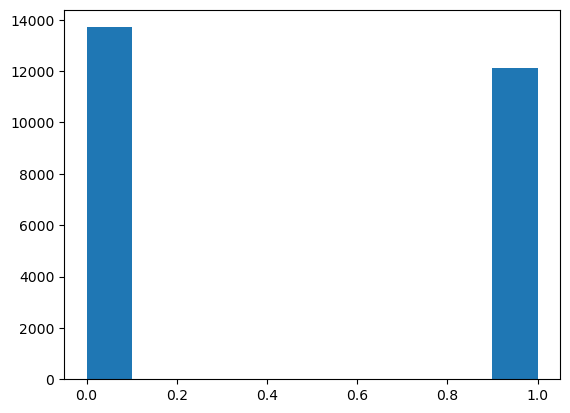

In [6]:
#now let's do a violin plot for sex using seaborn

plt.hist(sex)
#see it's quite similar

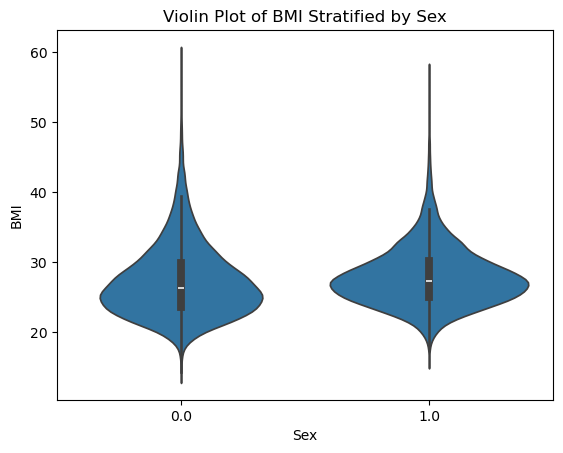

In [8]:
#now do a violin plot of bmi based on sex
data = pd.DataFrame({'Sex': sex, 'BMI': bmi})

# Create a violin plot
sns.violinplot(x='Sex', y='BMI', data=data)

# Display the plot
plt.title("Violin Plot of BMI Stratified by Sex")
plt.xlabel("Sex")
plt.ylabel("BMI")
plt.show()
#you can see they're quite similar, and are pretty good, now let's do a histogram stratified by sex as well


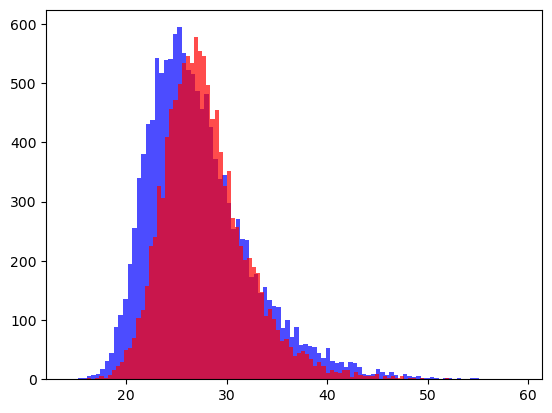

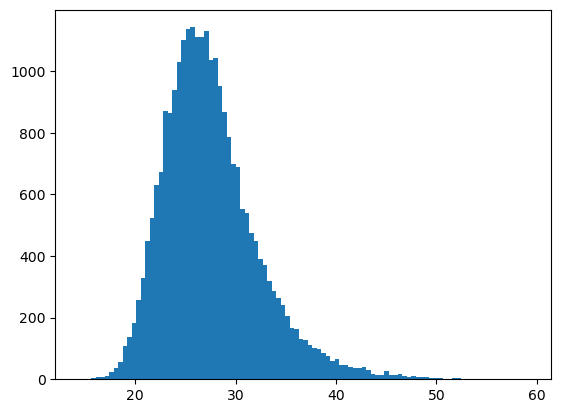

In [14]:
#now the histogram
male_bmi = bmi[sex==0]
female_bmi = bmi[sex==1]

plt.hist(male_bmi, color='blue', alpha=0.7, label='Male', bins=100)
plt.hist(female_bmi, color='red', alpha=0.7, label='Female', bins=100)
plt.show()

plt.hist(bmi, bins = 100)
plt.show()

#bmi whether by sex or not is veyr lognormal!

(array([ 290.,  555.,  524.,  588.,  636.,  635.,  607.,  645.,  613.,
         647.,  686.,  761.,  754.,  756.,  772.,  797.,  892.,  856.,
         934.,  981., 1224., 1390., 1349., 1193., 1154., 1211., 1136.,
        1048., 1000., 1184.]),
 array([39.        , 40.03333333, 41.06666667, 42.1       , 43.13333333,
        44.16666667, 45.2       , 46.23333333, 47.26666667, 48.3       ,
        49.33333333, 50.36666667, 51.4       , 52.43333333, 53.46666667,
        54.5       , 55.53333333, 56.56666667, 57.6       , 58.63333333,
        59.66666667, 60.7       , 61.73333333, 62.76666667, 63.8       ,
        64.83333333, 65.86666667, 66.9       , 67.93333333, 68.96666667,
        70.        ]),
 <BarContainer object of 30 artists>)

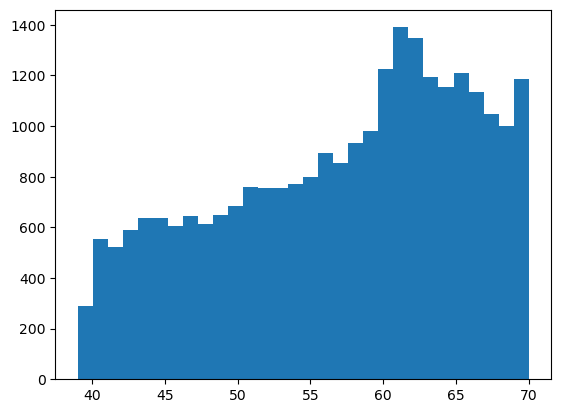

In [17]:
#now do for age
plt.hist(age, bins = 30)

In [24]:
#now let's find the parameters of the lognormal distribution BMI vector
from scipy.stats import norm
log_bmi = np.log(bmi[np.isnan(bmi)==False])

mu, sigma = norm.fit(log_bmi)
print(mu,sigma)

3.302698849019496 0.16570285818267133


In [23]:
#find how many nan in BMI
print(np.sum(np.isnan(bmi))) #just some nans for BMI...?
#now for age and sex
print(np.sum(np.isnan(age)))
print(np.sum(np.isnan(sex)))

134
0
0


In [26]:
num0 = np.sum(sex ==0)
num1 = np.sum(sex==1)
print(num0/(num1+num0))

0.5309474010380355
